<a href="https://colab.research.google.com/github/meovvmiao/AIPI-590-XAI/blob/main/hw4/aipi590_hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
### This homework was done without AI.
### Eleanor Jiang


[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meovvmiao/aipi-590-xai/blob/dev/hw4/aipi590_hw4.ipynb)

In [1]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "AIPI-590-XAI" # Change to your repo name
git_path = 'https://github.com/meovvmiao/AIPI-590-XAI.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
#!pip install -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = 'hw4'
# path_to_notebook = os.path.join(repo_name,notebook_dir)
path_to_notebook = os.path.join(repo_name, notebook_dir)
%cd "{path_to_notebook}"
%ls

rm: cannot remove './sample_data': No such file or directory
fatal: destination path 'AIPI-590-XAI' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'AIPI-590-XAI/hw4'
/content
AIPI-590-XAI/


In [2]:
!pip install numpy==1.25.2 pandas==2.0.3 matplotlib==3.7.1 scikit-learn==1.2.2 lime==0.2.0.1 anchor-exp==0.0.2.0 shap==0.45.1

  Using cached numpy-1.25.2.tar.gz (10.8 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-62b7v01y/alepython_f058dec4f9624bd0a4407a37a02f3264
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-62b7v01y/alepython_f058dec4f9624bd0a4407a37a02f3264
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for alepython: filename=alepython-0.1.dev17+g286350ab6-py3-none-any.whl size=15251 sha256=20fdc09a853b8def4311c50737db7354eb60f261a0f45f2a9700b2cb549b7d05
  Stored in directory: /tmp/pip-ephem-wheel-cache-tb1yxi97/wheels/87/54/8b/9357059e0e9ade0ea889a30fe56beaed44312e07475133b2cc
Successfully built alepython


In [4]:
# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
import xgboost
from sklearn.model_selection import train_test_split

from alepython import ale_plot
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import kagglehub

np.random.seed(1)

For convenience, I used the telco-customer-churn dataset from assignment 2.

In [5]:
# Download the dataset from Kaggle
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
# the following code was directly pasted from hw2
feature_columns = df.columns.tolist()[1:-1]
numeric_columns = df[feature_columns].select_dtypes(include=np.number).columns.tolist()
text_columns = df[feature_columns].select_dtypes(include=['object', 'category']).columns.tolist()

# code 'No phone service' to No
df['MultipleLines'] = df['MultipleLines'].replace('No phone service', 'No')
# code every other dummy categories to numbers
for col in text_columns:
  categories = df[col].unique()
  df[col] = df[col].replace(categories, range(len(categories)))

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# code TotalCharges to the correct datatype
df['TotalCharges'] = df['TotalCharges'].astype(float)

# perform simple NA fills
# if text, fill with mode
# if numeric, fill with median
for col in df.columns[1:-1]:
  if col in text_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
  else:
    df[col] = df[col].fillna(df[col].median())

# encode target variable
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})

/tmp/ipython-input-3864693790.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(categories, range(len(categories)))
/tmp/ipython-input-3864693790.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1})


In [7]:
# build a xgboost model
X, y = df[feature_columns], df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = xgboost.XGBClassifier().fit(X_train, y_train)

## Partial Dependence Plot

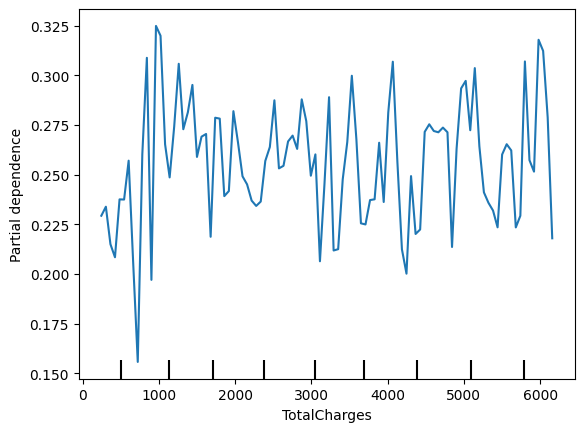

In [8]:
# feature of interest: TotalCharges
features = ["TotalCharges"]

# Use PartialDependenceDisplay to plot PDP
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average') #kind='both'

The y-axis values (around 0.20–0.32) indicate the marginal probability of churn given different levels of TotalCharges.

The plot is volatile, which aligns with our observation on the sparse distribution of TotalCharges.

Across most of the range of TotalCharges (from 0 to 6000), the churn probability hovers around 0.23–0.28, without a strong monotonic upward or downward trend.

There are some local spikes (e.g., near 1000, 3000, 6000) where churn probability increases above 0.30, but these may be artifacts of small sample sizes or non-linear model behavior.

In summary, TotalCharges might not be a strong feature in explaining customer churn based on our observation in PDP plot here.

## ALE Plot

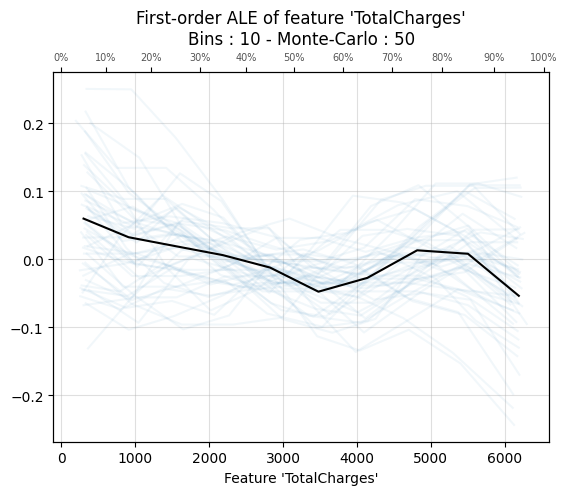

<Axes: title={'center': "First-order ALE of feature 'TotalCharges'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'TotalCharges'">

In [9]:
ale_plot(model, X_train, 'TotalCharges', monte_carlo=True)

By observing the black line (main trend):

- At low TotalCharges (<1000): The ALE effect is positive (~+0.05), meaning new/low-spending customers are slightly more likely to churn.

- As TotalCharges increases (1000–3500): The ALE line declines into the negative (~-0.05 to -0.1). This means customers with moderate spending history are less likely to churn than average.

- Around 4000–5000: The ALE effect increases back toward 0, suggesting churn risk returns closer to the baseline.

- Beyond 5000–6000: The ALE effect drops again slightly below 0.

Overall, it suggests a U-shaped relationship where churn risk is highest for brand-new and possibly very long-time customers, and lowest for medium-tenure customers.

## ICE Plot

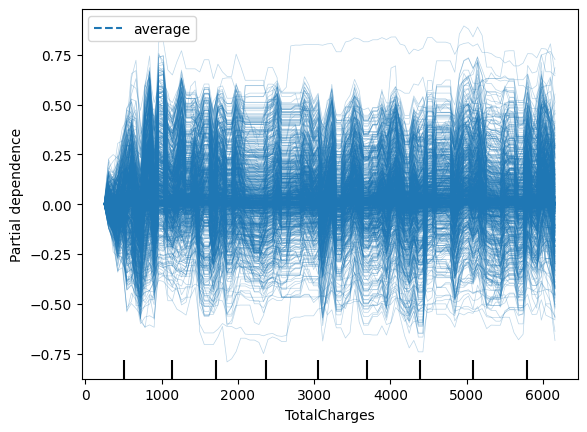

In [13]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', centered=True) #kind='individual'

In [14]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

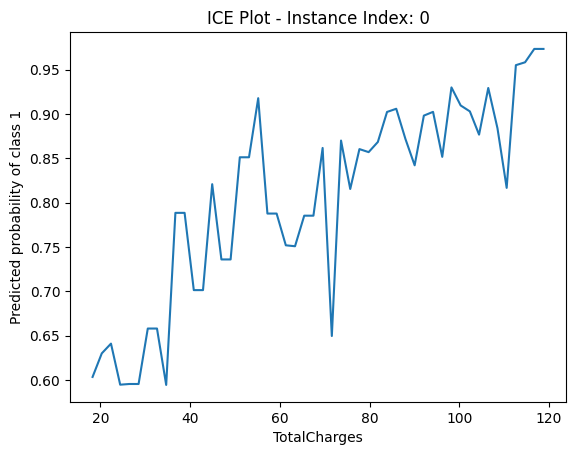

In [16]:
# Choose the instance and feature for which you want to plot the ICE plot
instance_index = 0  # Choose the index of the instance you want to visualize
feature_index = -2  # TotalCharges

# Create feature grid
feature_values = np.linspace(np.min(X.iloc[:, feature_index]), np.max(X.iloc[:, feature_index]), num=50)

# Initialize array to store average predictions
average_predictions = np.zeros_like(feature_values)

# Extract the instance of interest
instance = X.iloc[[instance_index]]

# Duplicate the instance to modify feature values
instance_modified = instance.copy()

# Loop over feature values
for i, value in enumerate(feature_values):
    # Set the chosen feature to the current value for the instance:
    instance_modified.iloc[:, feature_index] = value

    # Predict using the modified instance:
    prediction = model.predict_proba(instance_modified)[:, 1]

    # Store the prediction for the current feature value:
    average_predictions[i] = prediction.item()

# Plot the ICE plot
plt.plot(feature_values, average_predictions)
plt.xlabel(f'TotalCharges')
plt.ylabel('Predicted probability of class 1')
plt.title(f'ICE Plot - Instance Index: {instance_index}')
plt.show()

As TotalCharges increases from ~20 to 120, the predicted probability of churn for this customer steadily increases.

Starts around 0.60 churn probability at low TotalCharges, and rises to ~0.95 churn probability at high TotalCharges.

There is some local noise and fluctuations, but the overall trend is monotonically upward.

For this particular customer, if their TotalCharges were low, the model would predict a lower churn probability (~60%). As TotalCharges rises, the model becomes increasingly confident they would churn, peaking near 95%.

This suggests that, for this individual, the model has learned an association where higher accumulated charges correspond to higher churn risk.